# Preprocessing step

In [32]:
%pip install soundata numpy librosa matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [13]:
import soundata
import numpy as np

## Required for compatibility with the soundata library
np.float_ = np.float64

dataset = soundata.initialize('urbansound8k')
dataset.download()
dataset.validate()

example_clip = dataset.choice_clip() 
print(example_clip)

INFO: Downloading ['all', 'index']. Index is being stored in /home/guus/vscodeProjects/api-multi-label-classification/.venv/lib/python3.10/site-packages/soundata/datasets/indexes, and the rest of files in /home/guus/sound_datasets/urbansound8k
INFO: [all] downloading UrbanSound8K.tar.gz
INFO: /home/guus/sound_datasets/urbansound8k/UrbanSound8K.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: /home/guus/sound_datasets/urbansound8k/UrbanSound8K_README.txt already exists. Run with force_overwrite=True to download from scratch
INFO: /home/guus/sound_datasets/urbansound8k/metadata already exists. Run with force_overwrite=True to download from scratch
INFO: /home/guus/sound_datasets/urbansound8k/FREESOUNDCREDITS.txt already exists. Run with force_overwrite=True to download from scratch
INFO: /home/guus/sound_datasets/urbansound8k/audio already exists. Run with force_overwrite=True to download from scratch
INFO

Clip(
  audio_path="/home/guus/sound_datasets/urbansound8k/audio/fold7/66619-2-0-22.wav",
  clip_id="66619-2-0-22",
  audio: The clip's audio
            * np.ndarray - audio signal
            * float - sample rate,
  class_id: The clip's class id.
            * int - integer representation of the class label (0-9). See Dataset Info in the documentation for mapping,
  class_label: The clip's class label.
            * str - string class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music,
  fold: The clip's fold.
            * int - fold number (1-10) to which this clip is allocated. Use these folds for cross validation,
  freesound_end_time: The clip's end time in Freesound.
            * float - end time in seconds of the clip in the original freesound recording,
  freesound_id: The clip's Freesound ID.
            * str - ID of the freesound.org recording from which this clip was taken,
  freesound_start_ti

## melspectogram instructions
Goal: mel spectogram with resolution of 48 frequencies from 40hz upto 16khz.
with 32 time steps of 1/16th of a second with a half overlap during 1 second.
We assume the data is streaming.
data from the last 1/32th of the last second of the previous sample is added to the next.
so in total 48 frequency bands and 32 spectra
- audio sample between 1 and 16 seconds
- apply hann window function
- apply fourier transform to get absolute spectrum
- summize spectral components using MEL filters.
MEL spectral filters should be done using melbankm.m from VOICEBOX speech processing toolbox. http://www.ee.ic.ac.uk/hp/staff/dmb/voicebox/voicebox.html
as follows: [m,mc,mn]=melbankm(p,n,fs,fl,fh,w) where p=48,n=3000,fs=48000,fl=40,fh=16000,w="ch"
output m is matrix of filter values, mc and mn are frequency border and indices
- After this output the matrix is edited as follows
  - log on all components using natural log and a low pass filter of epsil = 1e-6, so x = log(Svalue, epsil)
  - normalize the mel spectro gram for training and classification, so all melspectograms have max value of 2:
Xnorm(:,:) = X(:,:)- max(max(X(:,:))) +2;

In [14]:
import librosa
import matplotlib.pyplot as plt

sample_rate = 48000
number_fft = 3000
number_mel_bands = 48
frequency_min = 40
frequency_max = 16000

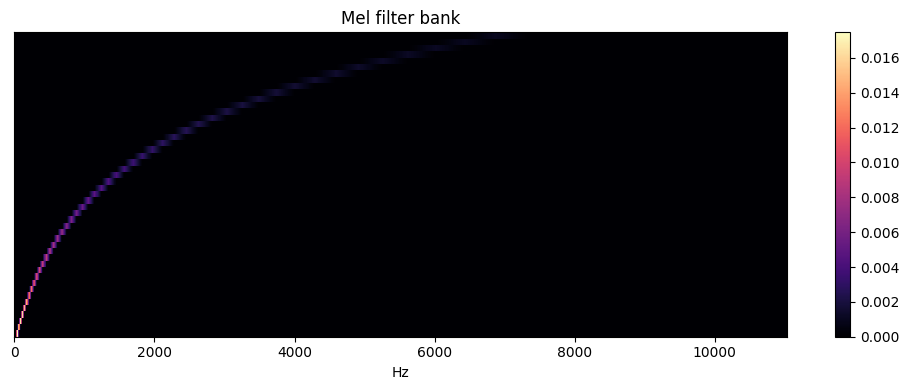

In [15]:
mel_filter_bank = librosa.filters.mel(sr=sample_rate, 
                                      n_fft=number_fft, 
                                      n_mels=number_mel_bands, 
                                      fmin=frequency_min, 
                                      fmax=frequency_max, 
                                      htk=True)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_filter_bank, x_axis='linear')
plt.colorbar()
plt.title('Mel filter bank')
plt.tight_layout()
plt.show()

In [ ]:
half_overlap = number_fft // 2

def readAudioSample(clip):
    audio, _ = librosa.load(clip.audio_path, sr=sample_rate)
    return audio

def applyHannWindow(audio):
    audio_windowed = audio * np.hanning(len(audio))
    return audio_windowed

def computeSpectrogram(audio_windowed):
    S = np.abs(librosa.stft(audio_windowed, n_fft=number_fft, hop_length=half_overlap))
    return S

def applyMelFilterBank(S):
    S_mel = np.dot(mel_filter_bank, S)
    return S_mel

def processMelSpectrogram(S_mel):
    epsil = 1e-6
    S_mel_log = np.log(S_mel + epsil)
    S_mel_norm = S_mel_log - np.max(S_mel_log) + 2
    return S_mel_norm

In [ ]:
def plotSpectrogram(S, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), 
                             sr=sample_rate, 
                             fmin=frequency_min, 
                             fmax=frequency_max, 
                             hop_length=half_overlap, 
                             x_axis='time',
                             y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

['air_conditioner']


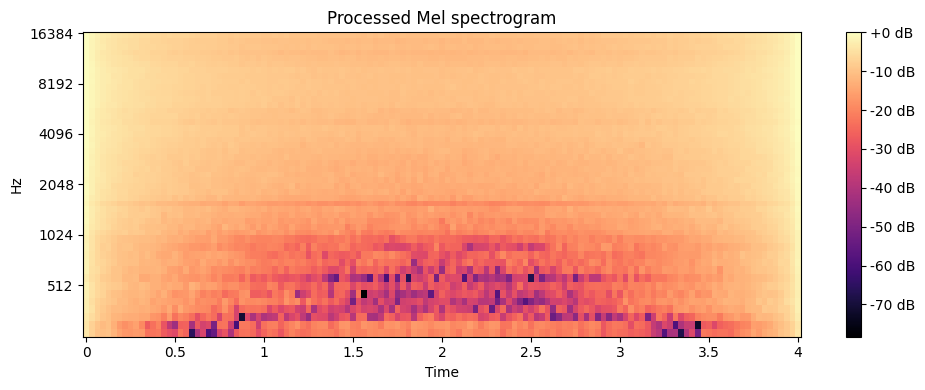

Validation result: True


In [ ]:
clip = dataset.choice_clip()

audio = readAudioSample(clip)
audio_windowed = applyHannWindow(audio)
S = computeSpectrogram(audio_windowed)
S_mel = applyMelFilterBank(S)
S_mel_processed = processMelSpectrogram(S_mel)
print(clip.tags.labels)
plotSpectrogram(S_mel_processed, 'Processed Mel spectrogram')

def validate_mel_spectrogram(S_mel_processed):
    if not (S_mel_processed.min() >= np.log(1e-6) and S_mel_processed.max() <= 2):
        raise ValueError("Frequency range is not valid")
    return True

# Validate the processed mel spectrogram
is_valid = validate_mel_spectrogram(S_mel_processed)
print(f"Validation result: {is_valid}")

# transforming the data

In [28]:
def getSpectrogram(clip):
    audio = readAudioSample(clip)
    audio_windowed = applyHannWindow(audio)
    S = computeSpectrogram(audio_windowed)
    S_mel = applyMelFilterBank(S)
    S_mel_processed = processMelSpectrogram(S_mel)
    return S_mel_processed

In [ ]:
import pandas as pd

data = []

for key, clip in dataset.load_clips().items():
    spec = getSpectrogram(clip)
    data.append([key, clip.audio_path, spec.tolist()])

df = pd.DataFrame(data, columns=['Key', 'AudioPath', 'Spectrogram'])

df.to_csv("data.csv", index=False)

135776-2-0-49 /home/guus/sound_datasets/urbansound8k/audio/fold1/135776-2-0-49.wav
46654-6-0-0 /home/guus/sound_datasets/urbansound8k/audio/fold1/46654-6-0-0.wav
57320-0-0-24 /home/guus/sound_datasets/urbansound8k/audio/fold1/57320-0-0-24.wav
134717-0-0-26 /home/guus/sound_datasets/urbansound8k/audio/fold1/134717-0-0-26.wav
174276-7-5-0 /home/guus/sound_datasets/urbansound8k/audio/fold1/174276-7-5-0.wav
180937-7-2-6 /home/guus/sound_datasets/urbansound8k/audio/fold1/180937-7-2-6.wav
17913-4-0-1 /home/guus/sound_datasets/urbansound8k/audio/fold1/17913-4-0-1.wav
103074-7-4-6 /home/guus/sound_datasets/urbansound8k/audio/fold1/103074-7-4-6.wav
176787-5-0-9 /home/guus/sound_datasets/urbansound8k/audio/fold1/176787-5-0-9.wav
55020-4-0-11 /home/guus/sound_datasets/urbansound8k/audio/fold1/55020-4-0-11.wav
138015-3-0-7 /home/guus/sound_datasets/urbansound8k/audio/fold1/138015-3-0-7.wav
180937-7-0-4 /home/guus/sound_datasets/urbansound8k/audio/fold1/180937-7-0-4.wav
180937-7-1-13 /home/guus/sou

/home/guus/vscodeProjects/api-multi-label-classification/.venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=3000 is too large for input signal of length=2400
  warnings.warn(


177621-0-0-128 /home/guus/sound_datasets/urbansound8k/audio/fold1/177621-0-0-128.wav
177621-0-0-100 /home/guus/sound_datasets/urbansound8k/audio/fold1/177621-0-0-100.wav
24074-1-0-4 /home/guus/sound_datasets/urbansound8k/audio/fold1/24074-1-0-4.wav
134717-0-0-9 /home/guus/sound_datasets/urbansound8k/audio/fold1/134717-0-0-9.wav
177621-0-0-54 /home/guus/sound_datasets/urbansound8k/audio/fold1/177621-0-0-54.wav
176787-5-0-10 /home/guus/sound_datasets/urbansound8k/audio/fold1/176787-5-0-10.wav
172314-9-0-72 /home/guus/sound_datasets/urbansound8k/audio/fold1/172314-9-0-72.wav
174290-6-2-0 /home/guus/sound_datasets/urbansound8k/audio/fold1/174290-6-2-0.wav
71087-4-1-0 /home/guus/sound_datasets/urbansound8k/audio/fold1/71087-4-1-0.wav
108362-2-0-12 /home/guus/sound_datasets/urbansound8k/audio/fold1/108362-2-0-12.wav
46656-6-2-0 /home/guus/sound_datasets/urbansound8k/audio/fold1/46656-6-2-0.wav
78360-4-0-1 /home/guus/sound_datasets/urbansound8k/audio/fold1/78360-4-0-1.wav
159738-8-0-13 /home/

KeyboardInterrupt: 

# below is debugging

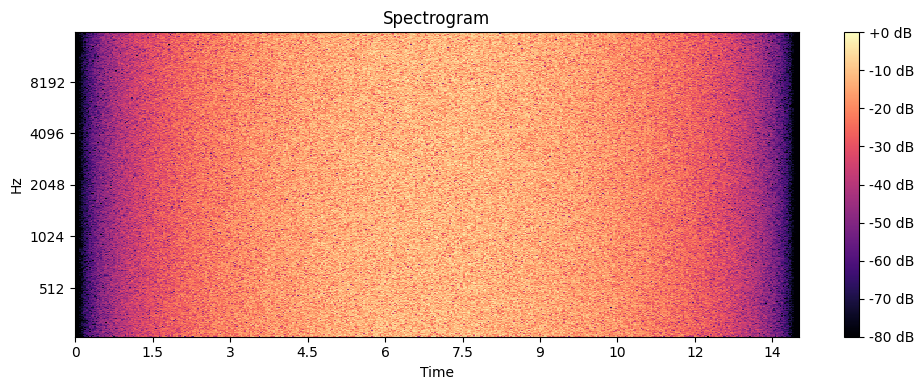

In [ ]:
import numpy as np

# Random sample
audio_sample_duration = np.random.randint(1, 17)
total_samples = int(sample_rate * audio_sample_duration)

audio_data = np.random.randn(total_samples)
audio_windowed = applyHannWindow(audio_data)

S = computeSpectrogram(audio_windowed)
S_mel = applyMelFilterBank(S)

plotSpectrogram(S, 'Spectrogram')